# Geometric Tensor Learning
---

In [1]:
import numpy as np
import numpy.ma as ma
from numpy.linalg import norm
import matplotlib.pyplot as plt

import networkx as nx
import project_path

from util.t2m import t2m
from util.m2t import m2t
from util.horpca import horpca
from util.hosvd import hosvd
from util.generate_data import generate_syn_data
from util.contaminate_data import contaminate_signal

In [2]:
sizes = (10,10,10,10)
ranks = (3,3,3,3)
n = len(sizes)

In [3]:
G = [nx.erdos_renyi_graph(sizes[i],0.3) for i in range(n)] # List of graphs for each mode
Phi = [nx.laplacian_matrix(G[i]).todense() for i in range(n)]


In [4]:
def graph_filter(Lambda, filter_length=1):
    ''' Graph filter generating the graph stationary data.
    '''
    h = np.random.rand(filter_length)
    return sum(h[i]**i*Lambda**i for i in range(filter_length))

In [5]:
## Generate data by multiplying the eigenvectors of the Graph Laplacian
# with i.i.d. Gaussian noise with variance given by the eigenvalues of the Laplacian.

V = []
for i in range(n):
    w, temp_v = np.linalg.eig(Phi[i])
    ind = np.argsort(abs(w))
    print(w[ind])
    V.append(temp_v[:,ind])
    if not(i):
        W_all = w[ind]
    else:
        W_all = np.kron(np.ones(w.size), W_all) + np.kron(w[ind],np.ones(W_all.size).flatten('F'))

C = np.random.randn(np.prod(sizes))
C[W_all<1e-8] = 0
C[W_all>1e-8] = C[W_all>1e-8] / W_all[W_all>1e-8]
C = C.reshape(sizes)

# C = W_all.reshape(sizes)**-1
X_smooth = C.copy()
for i in range(n):
    X_smooth = m2t(V[i]*t2m(X_smooth,i), sizes, i)

Y = contaminate_signal(X_smooth, target_SNR=-1)

In [6]:
Z = hosvd(Y, ranks)[0]

In [7]:
norm(Z-X)/norm(X)

0.04893044305359729

In [8]:
norm(Y-X)/norm(X)

0.3143017804840133

In [6]:
# Generate data smooth in Cartesian graph G.
# X = generate_syn_data(sizes, ranks)
# Y = contaminate_signal(X, target_SNR=10)
# V_all = 1

# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     if not(i):
#         W_all = W
#     else:
#         W_all = np.kron(np.ones(W.size), W_all) + np.kron(W,np.ones(W_all.size).flatten('F'))
#     V_all = np.kron(V_all, V)

# eigs = graph_filter(W_all)
# H = V_all@np.diag(eigs)@V_all.transpose()
# X = np.tensordot(H, np.random.randn(H.shape[1]), axes=([1],[0])).reshape(sizes)
# Y = contaminate_signal(X, target_SNR=15)
# del W_all, V_all, H

In [7]:


# covs = []
# X_smooth = np.zeros(sizes)
# for i in range(n):
#     W, V = np.linalg.eigh(Phi[i])
#     eigs = graph_filter(W)
#     H = V@np.diag(eigs)@V.transpose()
#     covs.append(H @ H)

#     col_inds = np.setdiff1d(np.arange(n), 1)
#     sz = np.array(sizes)
#     sz_cols = np.prod(sz[col_inds])
#     mean_temp = np.zeros(Phi[i].shape[0])
#     Xmat = np.random.multivariate_normal(mean_temp, covs[i], sz_cols).transpose()
#     X_smooth = X_smooth + m2t(Xmat, sizes, i)

# Y = contaminate_signal(X_smooth, target_SNR=15)

In [8]:
L, obj_val, terms = horpca(Y, psi=[1,1,1,1], beta=1, alpha=np.ones(4)*10**-2, max_iter=500, verbose=True)

Converged!


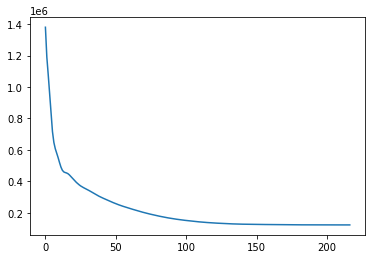

In [9]:
plt.plot(obj_val)

In [13]:
# X = X_smooth
norm(X-L)/norm(X)

0.3186542311368235

In [15]:
norm(X-Y.data)/norm(X)

0.0002556433578148683

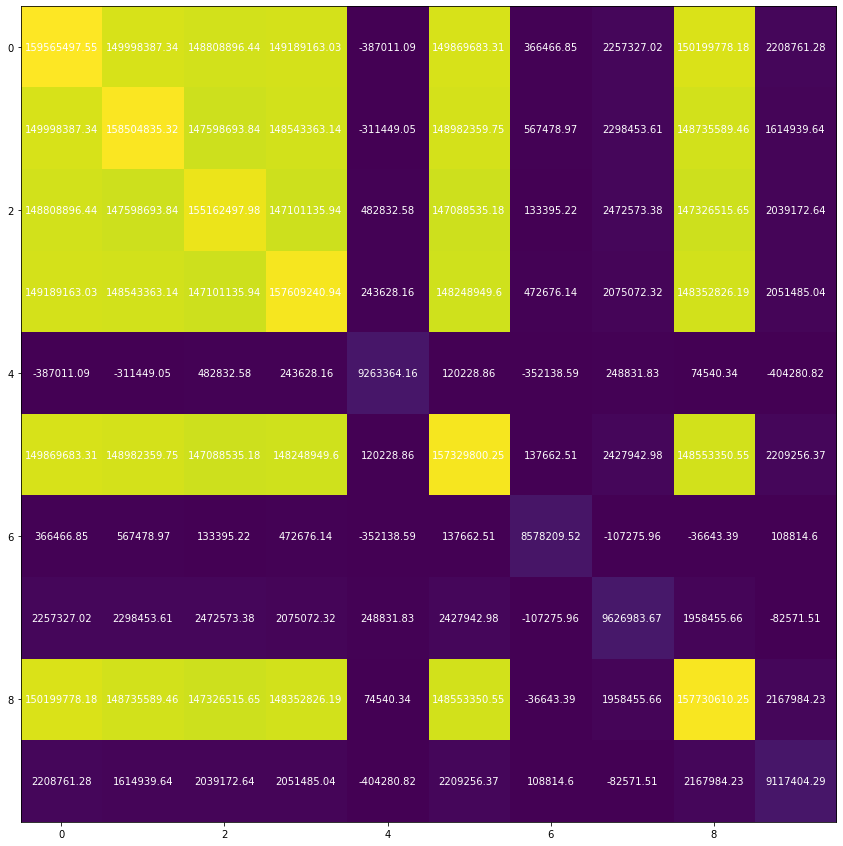

In [12]:
Ymat = t2m(Y.data, 0)
cov = Ymat@Ymat.transpose()

fig, ax = plt.subplots(figsize = (15,15))
im = ax.imshow(cov)

for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        text = ax.text(j, i, np.round(cov[i, j], 2) ,
                       ha="center", va="center", color="w")